In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'crazy-coffee-jam'

from google.cloud import bigquery

# Initialize the BigQuery client
client = bigquery.Client(project=project_id)

In [2]:
query = """ 
with c as
(
  select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.win_level`
  where level >= 15 
  AND user_pseudo_id IN (
    SELECT DISTINCT user_pseudo_id 
    FROM `crazy-coffee-jam.flatten_table.first_open` 
    WHERE event_date >= '2025-05-01'  
  )
)
, b as (
select user_pseudo_id, count(*) as time_start 
from `crazy-coffee-jam.flatten_table.start_level`
where user_pseudo_id in (select user_pseudo_id from c)
and level <= 15
group by  user_pseudo_id
having time_start >= 15
)
SELECT 
  user_pseudo_id, 
  COUNT(*) AS start_time
FROM `crazy-coffee-jam.flatten_table.start_level`
WHERE level <= 15 
  AND user_pseudo_id IN (SELECT DISTINCT user_pseudo_id FROM b )
GROUP BY user_pseudo_id
"""
user_segment = client.query(query).to_dataframe()
user_segment

,user_pseudo_id,start_time
0,7ed409be662409c873a35967f04e7734,20
1,db4d4743580893cd9466a5bb2c9a714e,15
2,e6eeb774859851d57e5193bcb8f6923a,15
3,0a4bb4e2e645d319f765aa834ce766d0,15
4,0d5806180dca3b11ff2b7664ea153edb,23
...,...,...
5678,be221bd1507534697a372a389f3c905b,16
5679,c688f8db9c75e158a0c9a4af8a3c5eee,15
5680,d1cbb9eba252d03acefd1e95a557bc27,17
5681,db77024183846ffac6f34aeba9cbf963,15


In [3]:
# prompt: Sử dụng dataframe user_segment:  thêm cột cluster: good cho user có start_time = 15, not_good cho nhóm còn lại. Sau đó đếm số lượng mỗi nhóm

# Thêm cột 'cluster' dựa trên điều kiện start_time
user_segment['cluster'] = user_segment['start_time'].apply(lambda x: 'good' if x == 15 else 'not_good')

# Đếm số lượng mỗi nhóm
cluster_counts = user_segment['cluster'].value_counts()

# In kết quả đếm số lượng
cluster_counts

cluster
good        3553
not_good    2130
Name: count, dtype: int64

In [4]:
# prompt: Tạo 2 list cho 2 nhóm user vừa cluster ra 

good_users = user_segment[user_segment['cluster'] == 'good']['user_pseudo_id'].tolist()
not_good_users = user_segment[user_segment['cluster'] == 'not_good']['user_pseudo_id'].tolist()

In [5]:
good_user_list_str = "', '".join(good_users)
not_good_user_list_str = "', '".join(not_good_users)

In [16]:
# Winrate vs
# Convert list of good users to comma-separated string of quoted IDs
good_user_list_str = "', '".join(good_users)

query1 = """
WITH start_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_start,
    COUNT( DISTINCT user_pseudo_id) as user_start
  FROM `crazy-coffee-jam.flatten_table.start_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
win_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_win,
    COUNT( DISTINCT user_pseudo_id) as user_win
  FROM `crazy-coffee-jam.flatten_table.win_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
lose_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_lose,
    COUNT( DISTINCT user_pseudo_id) as user_lose
  FROM `crazy-coffee-jam.flatten_table.lose_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
revive_events as (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_revive,
    COUNT( DISTINCT user_pseudo_id) as user_revive
  FROM `crazy-coffee-jam.flatten_table.revive_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
booster_use as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_booster_use
  FROM `crazy-coffee-jam.flatten_table.booster_use`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
ad_reward as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_ad_reward
  FROM `crazy-coffee-jam.flatten_table.af_rewarded`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
play_level_time as (
  SELECT
    level,
    sum(count_sec) as play_level_time_sec
  FROM `crazy-coffee-jam.flatten_table.all_play_level_time`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
),
win_level_time as (
  SELECT
    level,
    sum(count_sec) as play_level_time_sec
  FROM `crazy-coffee-jam.flatten_table.win_level_time`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{good_user_list_str}')
  GROUP BY  level
)
SELECT 
  s.level,
  s.event_start as event_start_good_user,
  w.event_win as event_win_good_user,
  l.event_lose as event_lose_good_user,
  r.event_revive as event_revive_good_user,
  s.user_start as user_start_good_user,
  b.num_booster_use as num_booster_use_good_user,
  a.num_ad_reward as num_ad_reward_good_user,
  p.play_level_time_sec as play_level_time_sec_good_user,
  wl.play_level_time_sec as win_level_time_sec_good_user
FROM start_events s
LEFT JOIN win_events w
  ON s.level = w.level
LEFT JOIN lose_events l
  ON s.level = l.level
LEFT JOIN revive_events r
  ON s.level = r.level
LEFT JOIN booster_use b
  ON s.level = b.level
LEFT JOIN ad_reward a
  ON s.level = a.level
LEFT JOIN play_level_time p
  ON s.level = p.level
LEFT JOIN win_level_time wl
  ON s.level = wl.level
  
"""

# Format the query with the actual user list string
query1 = query1.format(good_user_list_str=good_user_list_str)

# Execute query and store results
winrate_good_user = client.query(query1).to_dataframe()

# Winrate vs
# Convert list of good users to comma-separated string of quoted IDs
not_good_user_list_str = "', '".join(not_good_users)

query1 = """
WITH start_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_start,
    COUNT( DISTINCT user_pseudo_id) as user_start
  FROM `crazy-coffee-jam.flatten_table.start_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
win_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_win,
    COUNT( DISTINCT user_pseudo_id) as user_win
  FROM `crazy-coffee-jam.flatten_table.win_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
lose_events AS (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_lose,
    COUNT( DISTINCT user_pseudo_id) as user_lose
  FROM `crazy-coffee-jam.flatten_table.lose_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
revive_events as (
  SELECT
    level,
    COUNT(user_pseudo_id) as event_revive,
    COUNT( DISTINCT user_pseudo_id) as user_revive
  FROM `crazy-coffee-jam.flatten_table.revive_level`
  WHERE event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
booster_use as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_booster_use
  FROM `crazy-coffee-jam.flatten_table.booster_use`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
ad_reward as (
  SELECT
    level,
    COUNT(user_pseudo_id) as num_ad_reward
  FROM `crazy-coffee-jam.flatten_table.af_rewarded`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
play_level_time as (
  SELECT
    level,
    sum(count_sec) as play_level_time_sec
  FROM `crazy-coffee-jam.flatten_table.all_play_level_time`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
),
win_level_time as (
  SELECT
    level,
    sum(count_sec) as play_level_time_sec
  FROM `crazy-coffee-jam.flatten_table.win_level_time`
  where event_date >= '2025-05-01'
  AND user_pseudo_id IN ('{not_good_user_list_str}')
  GROUP BY  level
)
SELECT 
  s.level,
  s.event_start as event_start_not_good_user,
  w.event_win as event_win_not_good_user,
  l.event_lose as event_lose_not_good_user,
  r.event_revive as event_revive_not_good_user,
  s.user_start as user_start_not_good_user,
  b.num_booster_use as num_booster_use_not_good_user,
  a.num_ad_reward as num_ad_reward_not_good_user,
  p.play_level_time_sec as play_level_time_sec_not_good_user,
  wl.play_level_time_sec as win_level_time_sec_not_good_user
FROM start_events s
LEFT JOIN win_events w
  ON s.level = w.level
LEFT JOIN lose_events l
  ON s.level = l.level
LEFT JOIN revive_events r
  ON s.level = r.level
LEFT JOIN booster_use b
  ON s.level = b.level
LEFT JOIN ad_reward a
  ON s.level = a.level
LEFT JOIN play_level_time p
  ON s.level = p.level
LEFT JOIN win_level_time wl
  ON s.level = wl.level
"""

# Format the query with the actual user list string
query1 = query1.format(not_good_user_list_str=not_good_user_list_str)

# Execute query and store results
winrate_not_good_user = client.query(query1).to_dataframe()

In [17]:
# Merge the two dataframes on level and fill null values with 0
winrate_combined = pd.merge(winrate_good_user, winrate_not_good_user, 
                          on='level', 
                          how='outer').fillna(0)
winrate_combined

,level,event_start_good_user,event_win_good_user,event_lose_good_user,event_revive_good_user,user_start_good_user,num_booster_use_good_user,num_ad_reward_good_user,play_level_time_sec_good_user,win_level_time_sec_good_user,event_start_not_good_user,event_win_not_good_user,event_lose_not_good_user,event_revive_not_good_user,user_start_not_good_user,num_booster_use_not_good_user,num_ad_reward_not_good_user,play_level_time_sec_not_good_user,win_level_time_sec_not_good_user
0,1,2619,2620,0,0,2618,0,95,385736,385736,1284,1230,0,0,1195,0,37,180259,180407
1,2,2620,2620,0,0,2620,0,91,777783,777783,1251,1227,0,0,1197,0,16,363535,363831
2,3,2621,2620,0,0,2620,0,90,769882,769882,1239,1227,0,0,1197,0,17,358802,359098
3,4,2621,2619,0,0,2620,0,78,736648,736648,1248,1226,1,0,1196,0,17,340184,340175
4,5,2620,2610,0,0,2620,0,69,717197,717197,1271,1220,0,0,1195,0,14,332169,332451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,631,1,1,0,0,1,1,1,23,23,0,0,0,0,0,0,0,0,0
629,632,1,1,0,0,1,0,0,45,45,0,0,0,0,0,0,0,0,0
630,633,1,1,0,4,1,1,5,13,13,0,0,0,0,0,0,0,0,0
631,634,1,1,0,0,1,2,2,7,7,0,0,0,0,0,0,0,0,0


In [18]:
# Calculate winrates
winrate_combined['winrate_good_user'] = winrate_combined['event_win_good_user'] / (
    winrate_combined['event_win_good_user'] + 
    winrate_combined['event_lose_good_user'] + 
    winrate_combined['event_revive_good_user']
)

winrate_combined['winrate_not_good_user'] = winrate_combined['event_win_not_good_user'] / (
    winrate_combined['event_win_not_good_user'] + 
    winrate_combined['event_lose_not_good_user'] + 
    winrate_combined['event_revive_not_good_user']
)

# Get level 1 user starts
user_start_good_lv1 = winrate_combined.loc[winrate_combined['level'] == 1, 'user_start_good_user'].iloc[0]
user_start_not_good_lv1 = winrate_combined.loc[winrate_combined['level'] == 1, 'user_start_not_good_user'].iloc[0]

# Add level 1 user starts as columns
winrate_combined['user_start_good_user_lv1'] = user_start_good_lv1
winrate_combined['user_start_not_good_user_lv1'] = user_start_not_good_lv1

# Calculate drop rates from level 1
winrate_combined['drop_by_lv1_good_user'] = winrate_combined['user_start_good_user'] / winrate_combined['user_start_good_user_lv1']
winrate_combined['drop_by_lv1_not_good_user'] = winrate_combined['user_start_not_good_user'] / winrate_combined['user_start_not_good_user_lv1']


winrate_combined['num_booster_use_per_start_good_user'] = winrate_combined['num_booster_use_good_user'] / winrate_combined['user_start_good_user']
winrate_combined['num_booster_use_per_start_not_good_user'] = winrate_combined['num_booster_use_not_good_user'] / winrate_combined['user_start_not_good_user']

winrate_combined['num_ad_reward_per_start_good_user'] = winrate_combined['num_ad_reward_good_user'] / winrate_combined['user_start_good_user']
winrate_combined['num_ad_reward_per_start_not_good_user'] = winrate_combined['num_ad_reward_not_good_user'] / winrate_combined['user_start_not_good_user']

winrate_combined['play_level_time_sec_per_start_good_user'] = winrate_combined['play_level_time_sec_good_user'] / winrate_combined['user_start_good_user']
winrate_combined['play_level_time_sec_per_start_not_good_user'] = winrate_combined['play_level_time_sec_not_good_user'] / winrate_combined['user_start_not_good_user']

winrate_combined['win_level_time_sec_per_start_good_user'] = winrate_combined['win_level_time_sec_good_user'] / winrate_combined['user_start_good_user']
winrate_combined['win_level_time_sec_per_start_not_good_user'] = winrate_combined['win_level_time_sec_not_good_user'] / winrate_combined['user_start_not_good_user']

winrate_combined = winrate_combined[winrate_combined['level'] <= 50]
winrate_combined

,level,event_start_good_user,event_win_good_user,event_lose_good_user,event_revive_good_user,user_start_good_user,num_booster_use_good_user,num_ad_reward_good_user,play_level_time_sec_good_user,win_level_time_sec_good_user,...,drop_by_lv1_good_user,drop_by_lv1_not_good_user,num_booster_use_per_start_good_user,num_booster_use_per_start_not_good_user,num_ad_reward_per_start_good_user,num_ad_reward_per_start_not_good_user,play_level_time_sec_per_start_good_user,play_level_time_sec_per_start_not_good_user,win_level_time_sec_per_start_good_user,win_level_time_sec_per_start_not_good_user
0,1,2619,2620,0,0,2618,0,95,385736,385736,...,1.0,1.0,0.0,0.0,0.036287,0.030962,147.339954,150.844351,147.339954,150.968201
1,2,2620,2620,0,0,2620,0,91,777783,777783,...,1.000764,1.001674,0.0,0.0,0.034733,0.013367,296.86374,303.705096,296.86374,303.952381
2,3,2621,2620,0,0,2620,0,90,769882,769882,...,1.000764,1.001674,0.0,0.0,0.034351,0.014202,293.848092,299.751044,293.848092,299.998329
3,4,2621,2619,0,0,2620,0,78,736648,736648,...,1.000764,1.000837,0.0,0.0,0.029771,0.014214,281.163359,284.434783,281.163359,284.427258
4,5,2620,2610,0,0,2620,0,69,717197,717197,...,1.000764,1.0,0.0,0.0,0.026336,0.011715,273.739313,277.96569,273.739313,278.201674
5,6,2621,2619,1,1,2620,0,77,380396,380216,...,1.000764,0.999163,0.0,0.0,0.029389,0.014238,145.189313,142.180067,145.120611,142.155779
6,7,2619,2618,0,0,2618,0,81,452661,452661,...,1.0,0.999163,0.0,0.0,0.03094,0.01005,172.903361,175.546901,172.903361,175.691792
7,8,2627,2619,1,37,2620,2640,122,297775,297595,...,1.000764,1.001674,1.007634,1.087719,0.046565,0.052632,113.65458,102.281537,113.585878,96.769424
8,9,2617,2618,0,3,2616,18,86,343709,343709,...,0.999236,1.000837,0.006881,0.020067,0.032875,0.019231,131.387232,123.329431,131.387232,122.416388
9,10,2621,2620,0,0,2619,5,82,414464,414464,...,1.000382,1.001674,0.001909,0.0,0.03131,0.017544,158.252768,157.365915,158.252768,157.504595


In [19]:
# Clip values greater than 1 to 1 for drop rate columns
winrate_combined['drop_by_lv1_good_user'] = winrate_combined['drop_by_lv1_good_user'].clip(upper=1)
winrate_combined['drop_by_lv1_not_good_user'] = winrate_combined['drop_by_lv1_not_good_user'].clip(upper=1)

winrate_combined

C:\Users\dungv\AppData\Local\Temp\ipykernel_11560\2083772944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winrate_combined['drop_by_lv1_good_user'] = winrate_combined['drop_by_lv1_good_user'].clip(upper=1)
C:\Users\dungv\AppData\Local\Temp\ipykernel_11560\2083772944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winrate_combined['drop_by_lv1_not_good_user'] = winrate_combined['drop_by_lv1_not_good_user'].clip(upper=1)


,level,event_start_good_user,event_win_good_user,event_lose_good_user,event_revive_good_user,user_start_good_user,num_booster_use_good_user,num_ad_reward_good_user,play_level_time_sec_good_user,win_level_time_sec_good_user,...,drop_by_lv1_good_user,drop_by_lv1_not_good_user,num_booster_use_per_start_good_user,num_booster_use_per_start_not_good_user,num_ad_reward_per_start_good_user,num_ad_reward_per_start_not_good_user,play_level_time_sec_per_start_good_user,play_level_time_sec_per_start_not_good_user,win_level_time_sec_per_start_good_user,win_level_time_sec_per_start_not_good_user
0,1,2619,2620,0,0,2618,0,95,385736,385736,...,1.0,1.0,0.0,0.0,0.036287,0.030962,147.339954,150.844351,147.339954,150.968201
1,2,2620,2620,0,0,2620,0,91,777783,777783,...,1.0,1.0,0.0,0.0,0.034733,0.013367,296.86374,303.705096,296.86374,303.952381
2,3,2621,2620,0,0,2620,0,90,769882,769882,...,1.0,1.0,0.0,0.0,0.034351,0.014202,293.848092,299.751044,293.848092,299.998329
3,4,2621,2619,0,0,2620,0,78,736648,736648,...,1.0,1.0,0.0,0.0,0.029771,0.014214,281.163359,284.434783,281.163359,284.427258
4,5,2620,2610,0,0,2620,0,69,717197,717197,...,1.0,1.0,0.0,0.0,0.026336,0.011715,273.739313,277.96569,273.739313,278.201674
5,6,2621,2619,1,1,2620,0,77,380396,380216,...,1.0,0.999163,0.0,0.0,0.029389,0.014238,145.189313,142.180067,145.120611,142.155779
6,7,2619,2618,0,0,2618,0,81,452661,452661,...,1.0,0.999163,0.0,0.0,0.03094,0.01005,172.903361,175.546901,172.903361,175.691792
7,8,2627,2619,1,37,2620,2640,122,297775,297595,...,1.0,1.0,1.007634,1.087719,0.046565,0.052632,113.65458,102.281537,113.585878,96.769424
8,9,2617,2618,0,3,2616,18,86,343709,343709,...,0.999236,1.0,0.006881,0.020067,0.032875,0.019231,131.387232,123.329431,131.387232,122.416388
9,10,2621,2620,0,0,2619,5,82,414464,414464,...,1.0,1.0,0.001909,0.0,0.03131,0.017544,158.252768,157.365915,158.252768,157.504595


In [21]:
# Add next level user starts
winrate_combined['user_good_start_next_level'] = winrate_combined['user_start_good_user'].shift(-1)
winrate_combined['user_not_good_start_next_level'] = winrate_combined['user_start_not_good_user'].shift(-1)

# Calculate drop by level
winrate_combined['drop_by_level_good_user'] = 1 - (winrate_combined['user_good_start_next_level'] / winrate_combined['user_start_good_user'])
winrate_combined['drop_by_level_not_good_user'] = 1 - (winrate_combined['user_not_good_start_next_level'] / winrate_combined['user_start_not_good_user'])

winrate_combined

C:\Users\dungv\AppData\Local\Temp\ipykernel_11560\3016884747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winrate_combined['user_good_start_next_level'] = winrate_combined['user_start_good_user'].shift(-1)
C:\Users\dungv\AppData\Local\Temp\ipykernel_11560\3016884747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winrate_combined['user_not_good_start_next_level'] = winrate_combined['user_start_not_good_user'].shift(-1)
C:\Users\dungv\AppData\Local\Temp\ipykernel_11560\3016884747.py:6: SettingWith

,level,event_start_good_user,event_win_good_user,event_lose_good_user,event_revive_good_user,user_start_good_user,num_booster_use_good_user,num_ad_reward_good_user,play_level_time_sec_good_user,win_level_time_sec_good_user,...,num_ad_reward_per_start_good_user,num_ad_reward_per_start_not_good_user,play_level_time_sec_per_start_good_user,play_level_time_sec_per_start_not_good_user,win_level_time_sec_per_start_good_user,win_level_time_sec_per_start_not_good_user,user_good_start_next_level,user_not_good_start_next_level,drop_by_level_good_user,drop_by_level_not_good_user
0,1,2619,2620,0,0,2618,0,95,385736,385736,...,0.036287,0.030962,147.339954,150.844351,147.339954,150.968201,2620,1197,-0.000764,-0.001674
1,2,2620,2620,0,0,2620,0,91,777783,777783,...,0.034733,0.013367,296.86374,303.705096,296.86374,303.952381,2620,1197,0.0,0.0
2,3,2621,2620,0,0,2620,0,90,769882,769882,...,0.034351,0.014202,293.848092,299.751044,293.848092,299.998329,2620,1196,0.0,0.000835
3,4,2621,2619,0,0,2620,0,78,736648,736648,...,0.029771,0.014214,281.163359,284.434783,281.163359,284.427258,2620,1195,0.0,0.000836
4,5,2620,2610,0,0,2620,0,69,717197,717197,...,0.026336,0.011715,273.739313,277.96569,273.739313,278.201674,2620,1194,0.0,0.000837
5,6,2621,2619,1,1,2620,0,77,380396,380216,...,0.029389,0.014238,145.189313,142.180067,145.120611,142.155779,2618,1194,0.000763,0.0
6,7,2619,2618,0,0,2618,0,81,452661,452661,...,0.03094,0.01005,172.903361,175.546901,172.903361,175.691792,2620,1197,-0.000764,-0.002513
7,8,2627,2619,1,37,2620,2640,122,297775,297595,...,0.046565,0.052632,113.65458,102.281537,113.585878,96.769424,2616,1196,0.001527,0.000835
8,9,2617,2618,0,3,2616,18,86,343709,343709,...,0.032875,0.019231,131.387232,123.329431,131.387232,122.416388,2619,1197,-0.001147,-0.000836
9,10,2621,2620,0,0,2619,5,82,414464,414464,...,0.03131,0.017544,158.252768,157.365915,158.252768,157.504595,2620,1196,-0.000382,0.000835


In [24]:
# Set drop by level values to 0 for levels 1-15
winrate_combined.loc[(winrate_combined['level'] >= 1) & (winrate_combined['level'] <= 15), 'drop_by_level_good_user'] = 0
winrate_combined.loc[(winrate_combined['level'] >= 1) & (winrate_combined['level'] <= 15), 'drop_by_level_not_good_user'] = 0


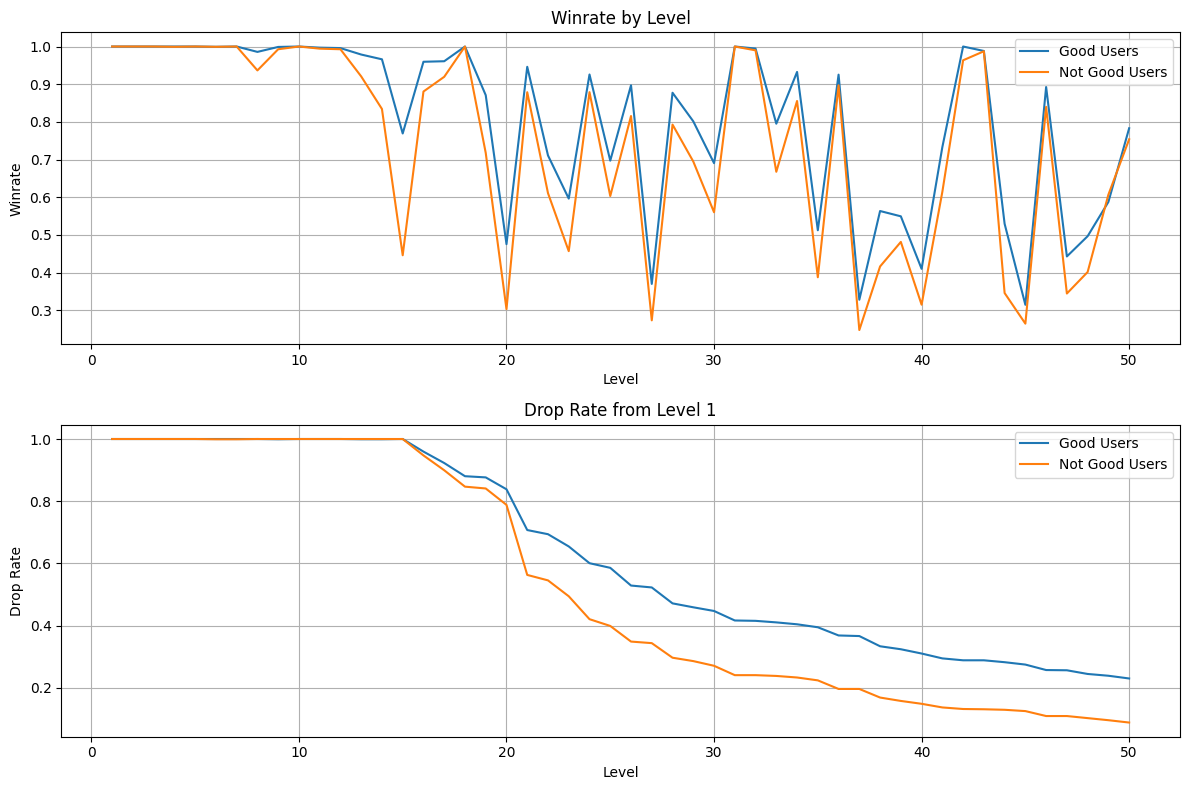

In [20]:
# Filter data for level <= 50
filtered_data = winrate_combined[winrate_combined['level'] <= 50]

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot winrates on first subplot
ax1.plot(filtered_data['level'], filtered_data['winrate_good_user'], label='Good Users')
ax1.plot(filtered_data['level'], filtered_data['winrate_not_good_user'], label='Not Good Users')
ax1.set_title('Winrate by Level')
ax1.set_xlabel('Level')
ax1.set_ylabel('Winrate')
ax1.legend()
ax1.grid(True)

# Plot drop rates on second subplot
ax2.plot(filtered_data['level'], filtered_data['drop_by_lv1_good_user'], label='Good Users')
ax2.plot(filtered_data['level'], filtered_data['drop_by_lv1_not_good_user'], label='Not Good Users')
ax2.set_title('Drop Rate from Level 1')
ax2.set_xlabel('Level')
ax2.set_ylabel('Drop Rate')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

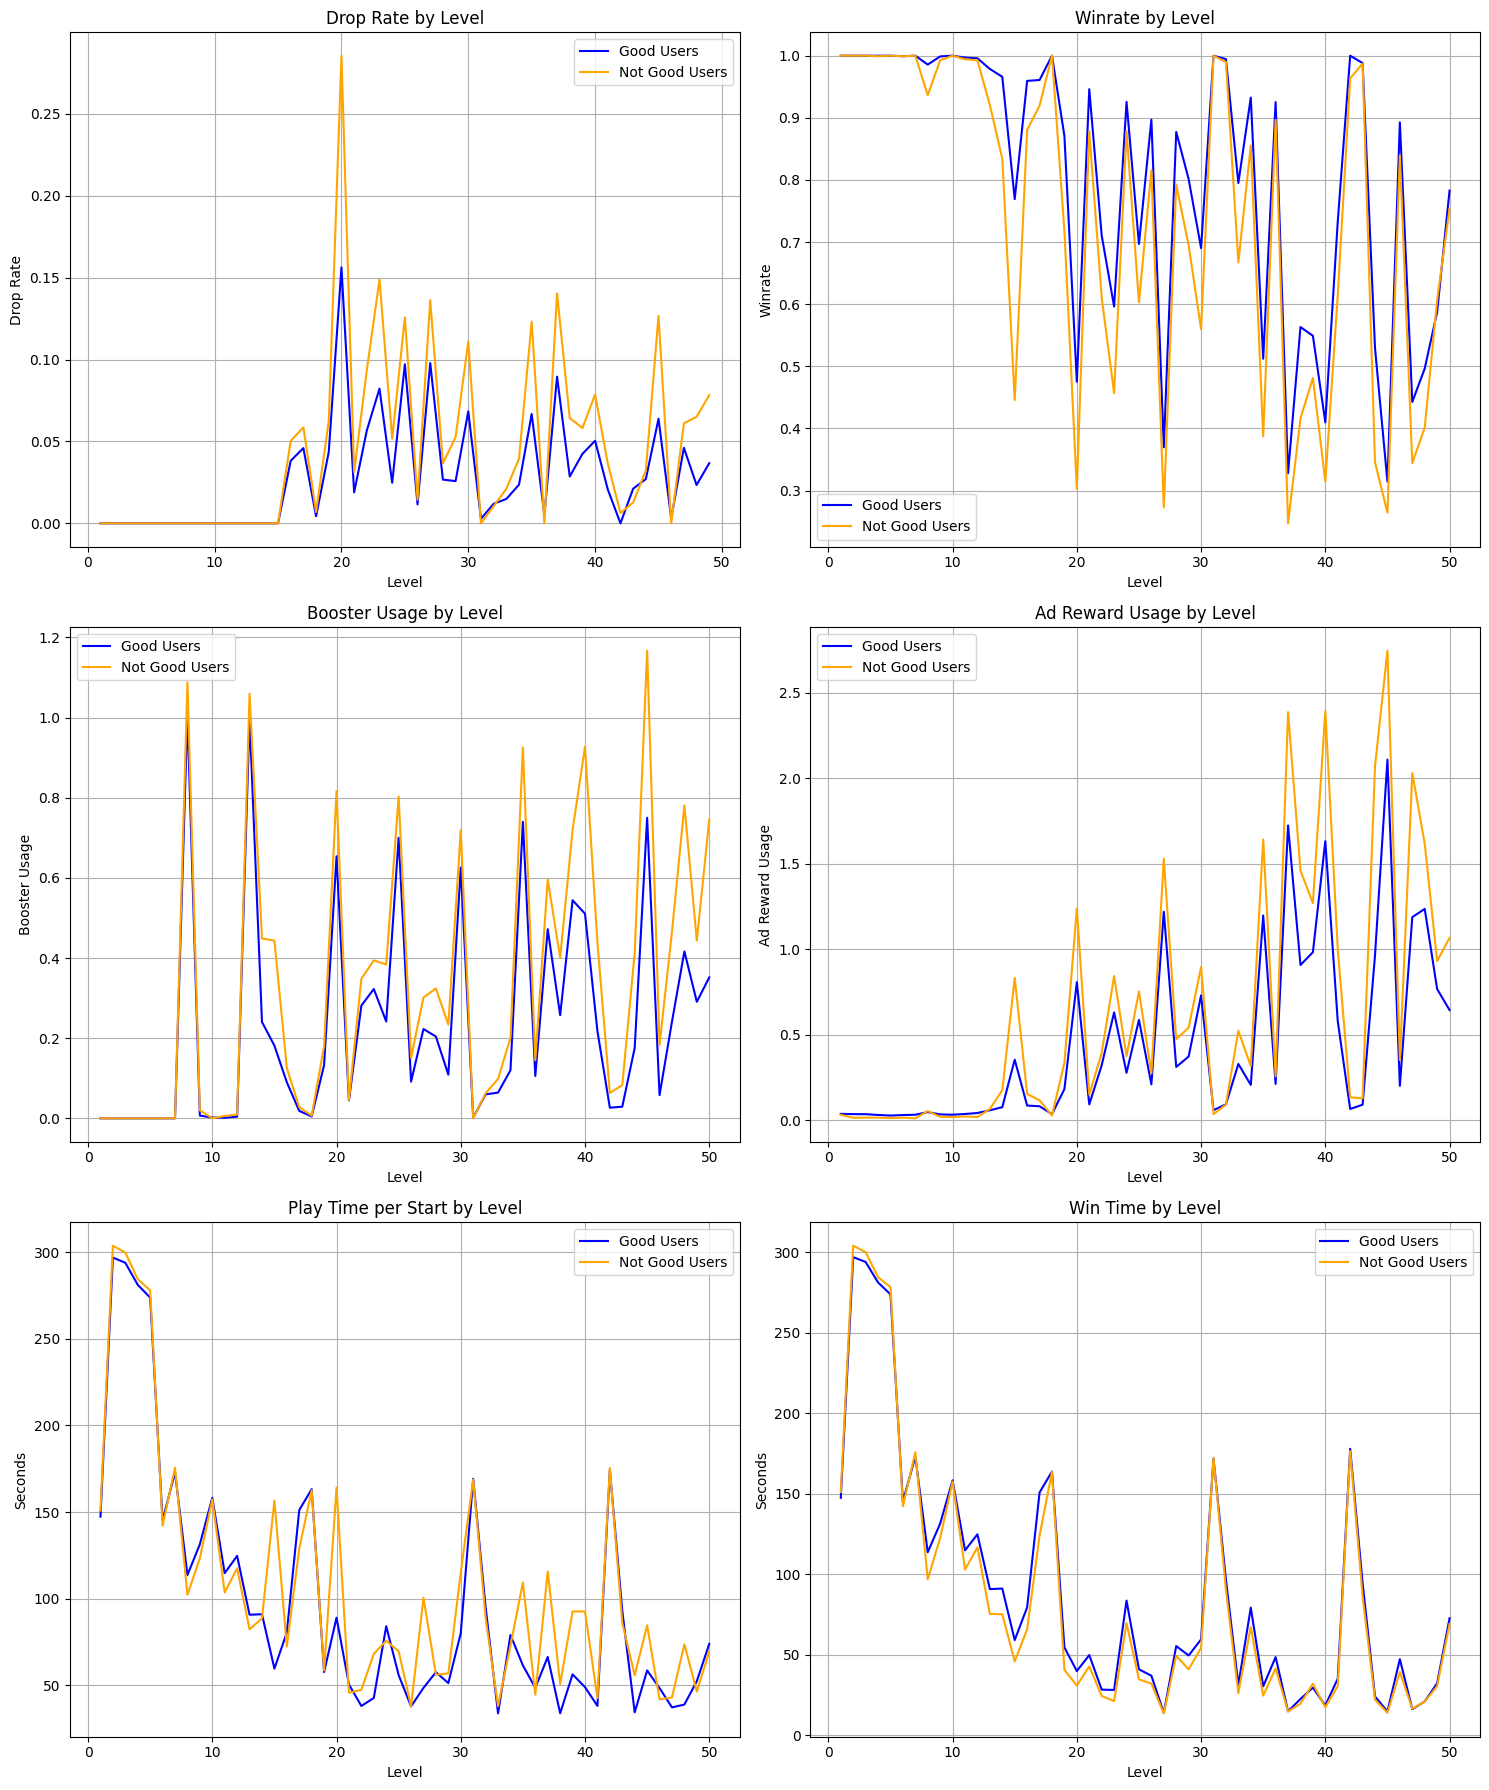

In [28]:
# Filter data for level <= 50
filtered_data = winrate_combined[winrate_combined['level'] <= 50]

# Create figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Plot drop rates by level
axes[0,0].plot(filtered_data['level'], filtered_data['drop_by_level_good_user'], color='blue', label='Good Users')
axes[0,0].plot(filtered_data['level'], filtered_data['drop_by_level_not_good_user'], color='orange', label='Not Good Users')
axes[0,0].set_title('Drop Rate by Level')
axes[0,0].set_xlabel('Level')
axes[0,0].set_ylabel('Drop Rate')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot winrates
axes[0,1].plot(filtered_data['level'], filtered_data['winrate_good_user'], color='blue', label='Good Users')
axes[0,1].plot(filtered_data['level'], filtered_data['winrate_not_good_user'], color='orange', label='Not Good Users')
axes[0,1].set_title('Winrate by Level')
axes[0,1].set_xlabel('Level')
axes[0,1].set_ylabel('Winrate')
axes[0,1].legend()
axes[0,1].grid(True)

# Plot booster usage
axes[1,0].plot(filtered_data['level'], filtered_data['num_booster_use_per_start_good_user'], color='blue', label='Good Users')
axes[1,0].plot(filtered_data['level'], filtered_data['num_booster_use_per_start_not_good_user'], color='orange', label='Not Good Users')
axes[1,0].set_title('Booster Usage by Level')
axes[1,0].set_xlabel('Level')
axes[1,0].set_ylabel('Booster Usage')
axes[1,0].legend()
axes[1,0].grid(True)

# Plot ad reward usage
axes[1,1].plot(filtered_data['level'], filtered_data['num_ad_reward_per_start_good_user'], color='blue', label='Good Users')
axes[1,1].plot(filtered_data['level'], filtered_data['num_ad_reward_per_start_not_good_user'], color='orange', label='Not Good Users')
axes[1,1].set_title('Ad Reward Usage by Level')
axes[1,1].set_xlabel('Level')
axes[1,1].set_ylabel('Ad Reward Usage')
axes[1,1].legend()
axes[1,1].grid(True)

# Plot play time per start
axes[2,0].plot(filtered_data['level'], filtered_data['play_level_time_sec_per_start_good_user'], color='blue', label='Good Users')
axes[2,0].plot(filtered_data['level'], filtered_data['play_level_time_sec_per_start_not_good_user'], color='orange', label='Not Good Users')
axes[2,0].set_title('Play Time per Start by Level')
axes[2,0].set_xlabel('Level')
axes[2,0].set_ylabel('Seconds')
axes[2,0].legend()
axes[2,0].grid(True)

# Plot win time
axes[2,1].plot(filtered_data['level'], filtered_data['win_level_time_sec_per_start_good_user'], color='blue', label='Good Users')
axes[2,1].plot(filtered_data['level'], filtered_data['win_level_time_sec_per_start_not_good_user'], color='orange', label='Not Good Users')
axes[2,1].set_title('Win Time by Level')
axes[2,1].set_xlabel('Level')
axes[2,1].set_ylabel('Seconds')
axes[2,1].legend()
axes[2,1].grid(True)

plt.tight_layout()
plt.show()

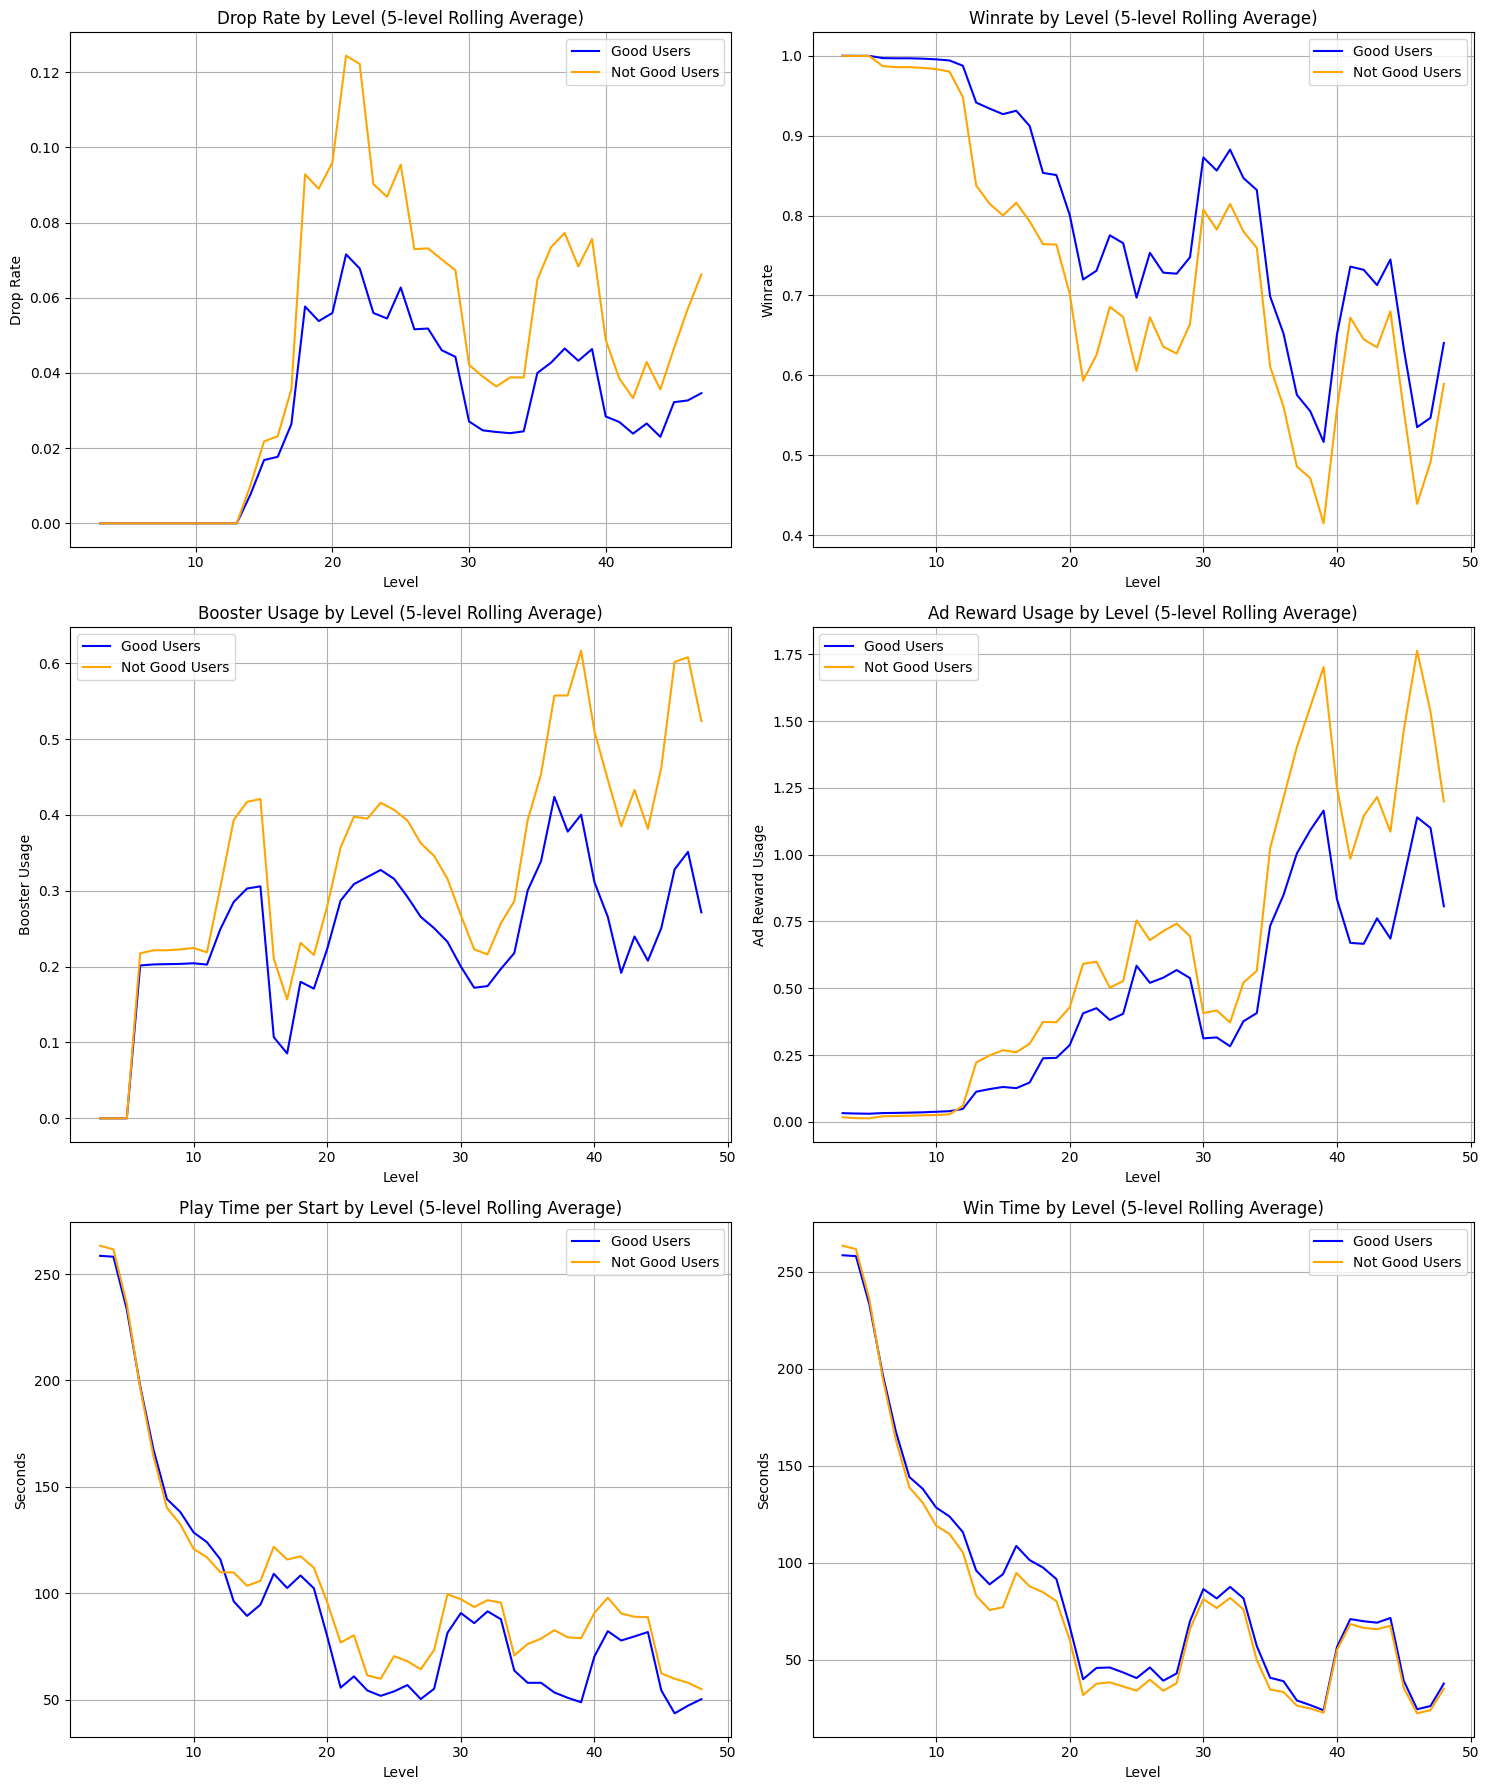

In [29]:
# Filter data for level <= 50
filtered_data = winrate_combined[winrate_combined['level'] <= 50]

# Create figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Calculate 5-level rolling averages
drop_good_rolling = filtered_data['drop_by_level_good_user'].rolling(window=5, center=True).mean()
drop_not_good_rolling = filtered_data['drop_by_level_not_good_user'].rolling(window=5, center=True).mean()
winrate_good_rolling = filtered_data['winrate_good_user'].rolling(window=5, center=True).mean()
winrate_not_good_rolling = filtered_data['winrate_not_good_user'].rolling(window=5, center=True).mean()
booster_good_rolling = filtered_data['num_booster_use_per_start_good_user'].rolling(window=5, center=True).mean()
booster_not_good_rolling = filtered_data['num_booster_use_per_start_not_good_user'].rolling(window=5, center=True).mean()
ad_good_rolling = filtered_data['num_ad_reward_per_start_good_user'].rolling(window=5, center=True).mean()
ad_not_good_rolling = filtered_data['num_ad_reward_per_start_not_good_user'].rolling(window=5, center=True).mean()
play_good_rolling = filtered_data['play_level_time_sec_per_start_good_user'].rolling(window=5, center=True).mean()
play_not_good_rolling = filtered_data['play_level_time_sec_per_start_not_good_user'].rolling(window=5, center=True).mean()
win_good_rolling = filtered_data['win_level_time_sec_per_start_good_user'].rolling(window=5, center=True).mean()
win_not_good_rolling = filtered_data['win_level_time_sec_per_start_not_good_user'].rolling(window=5, center=True).mean()

# Plot drop rates by level
axes[0,0].plot(filtered_data['level'], drop_good_rolling, color='blue', label='Good Users')
axes[0,0].plot(filtered_data['level'], drop_not_good_rolling, color='orange', label='Not Good Users')
axes[0,0].set_title('Drop Rate by Level (5-level Rolling Average)')
axes[0,0].set_xlabel('Level')
axes[0,0].set_ylabel('Drop Rate')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot winrates
axes[0,1].plot(filtered_data['level'], winrate_good_rolling, color='blue', label='Good Users')
axes[0,1].plot(filtered_data['level'], winrate_not_good_rolling, color='orange', label='Not Good Users')
axes[0,1].set_title('Winrate by Level (5-level Rolling Average)')
axes[0,1].set_xlabel('Level')
axes[0,1].set_ylabel('Winrate')
axes[0,1].legend()
axes[0,1].grid(True)

# Plot booster usage
axes[1,0].plot(filtered_data['level'], booster_good_rolling, color='blue', label='Good Users')
axes[1,0].plot(filtered_data['level'], booster_not_good_rolling, color='orange', label='Not Good Users')
axes[1,0].set_title('Booster Usage by Level (5-level Rolling Average)')
axes[1,0].set_xlabel('Level')
axes[1,0].set_ylabel('Booster Usage')
axes[1,0].legend()
axes[1,0].grid(True)

# Plot ad reward usage
axes[1,1].plot(filtered_data['level'], ad_good_rolling, color='blue', label='Good Users')
axes[1,1].plot(filtered_data['level'], ad_not_good_rolling, color='orange', label='Not Good Users')
axes[1,1].set_title('Ad Reward Usage by Level (5-level Rolling Average)')
axes[1,1].set_xlabel('Level')
axes[1,1].set_ylabel('Ad Reward Usage')
axes[1,1].legend()
axes[1,1].grid(True)

# Plot play time per start
axes[2,0].plot(filtered_data['level'], play_good_rolling, color='blue', label='Good Users')
axes[2,0].plot(filtered_data['level'], play_not_good_rolling, color='orange', label='Not Good Users')
axes[2,0].set_title('Play Time per Start by Level (5-level Rolling Average)')
axes[2,0].set_xlabel('Level')
axes[2,0].set_ylabel('Seconds')
axes[2,0].legend()
axes[2,0].grid(True)

# Plot win time
axes[2,1].plot(filtered_data['level'], win_good_rolling, color='blue', label='Good Users')
axes[2,1].plot(filtered_data['level'], win_not_good_rolling, color='orange', label='Not Good Users')
axes[2,1].set_title('Win Time by Level (5-level Rolling Average)')
axes[2,1].set_xlabel('Level')
axes[2,1].set_ylabel('Seconds')
axes[2,1].legend()
axes[2,1].grid(True)

plt.tight_layout()
plt.show()

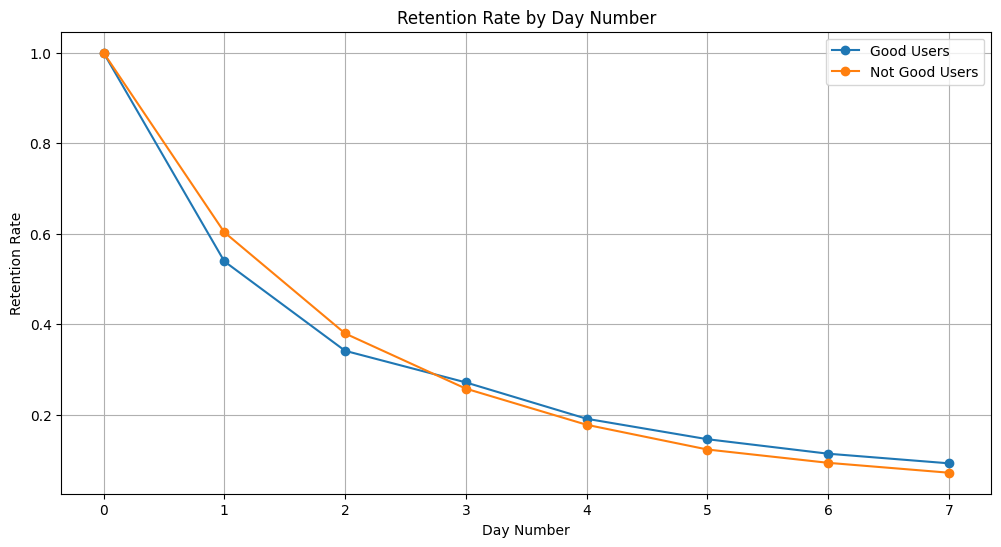

In [30]:
query = f""" 
with  first_open_dates as (
  select 
    user_pseudo_id,
    min(event_date) as first_open_date
  from `crazy-coffee-jam.flatten_table.first_open`
  where user_pseudo_id in ('{good_user_list_str}')
  and event_date >= '2025-05-01'
  group by user_pseudo_id 
),
engagement as (
select distinct user_pseudo_id, event_date  
from `crazy-coffee-jam.flatten_table.user_engagement` 
where event_date >= '2025-05-01'
),
 retention_data as (
  select
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    date_diff(e.event_date, f.first_open_date, DAY) as day_number
  from first_open_dates f
  left join engagement e
    on f.user_pseudo_id = e.user_pseudo_id
  where date_diff(e.event_date, f.first_open_date, DAY) between 0 and 7
)
  select
    day_number,
    count(distinct user_pseudo_id) as retained_users
  from retention_data
  group by day_number order by day_number
"""
ret_adrw = client.query(query).to_dataframe()
# Calculate retention rate relative to day 0 users
day0_users = ret_adrw.loc[ret_adrw['day_number']==0, 'retained_users'].iloc[0]
ret_adrw['retention_rate'] = ret_adrw['retained_users'] / day0_users

query = f""" 
with first_open_dates as (
  select 
    user_pseudo_id,
    min(event_date) as first_open_date
  from `crazy-coffee-jam.flatten_table.first_open`
  where user_pseudo_id in ('{not_good_user_list_str}')
  and event_date >= '2025-05-01'
  group by user_pseudo_id
), engagement as (
select distinct user_pseudo_id, event_date 
from `crazy-coffee-jam.flatten_table.user_engagement`
where event_date >= '2025-05-01'
), 
retention_data as (
  select
    f.user_pseudo_id,
    f.first_open_date,
    e.event_date,
    date_diff(e.event_date, f.first_open_date, DAY) as day_number
  from first_open_dates f
  left join engagement e
    on f.user_pseudo_id = e.user_pseudo_id
  where date_diff(e.event_date, f.first_open_date, DAY) between 0 and 7
)
  select
    day_number,
    count(distinct user_pseudo_id) as retained_users
  from retention_data
  group by day_number order by day_number
"""
ret_nonadrw = client.query(query).to_dataframe()
# Calculate retention rate relative to day 0 users
day0_users = ret_nonadrw.loc[ret_nonadrw['day_number']==0, 'retained_users'].iloc[0]
ret_nonadrw['retention_rate'] = ret_nonadrw['retained_users'] / day0_users

plt.figure(figsize=(12,6))
plt.plot(ret_adrw['day_number'], ret_adrw['retention_rate'], label='Good Users', marker='o')
plt.plot(ret_nonadrw['day_number'], ret_nonadrw['retention_rate'], label='Not Good Users', marker='o')
plt.xlabel('Day Number')
plt.ylabel('Retention Rate')
plt.title('Retention Rate by Day Number')
plt.grid(True)
plt.legend()
plt.show()

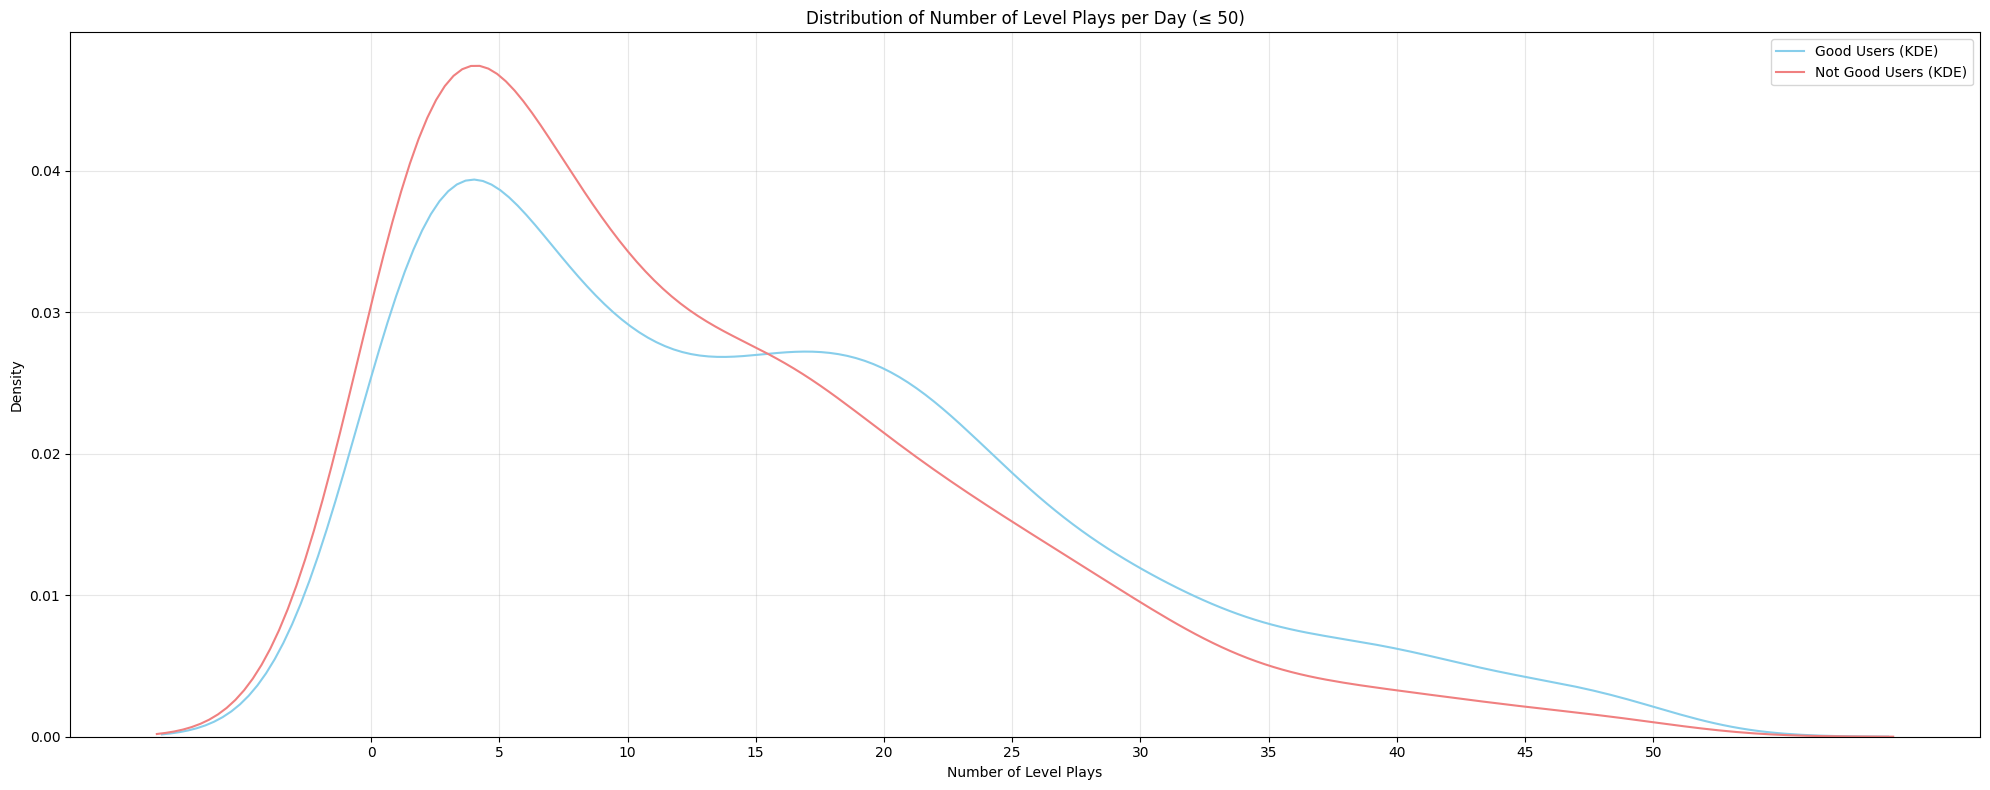

In [49]:
query1 = f"""
select *
from `crazy-coffee-jam.dashboard_table.avg_level_play`
where event_date >= '2025-05-01'
and user_pseudo_id in ('{good_user_list_str}')
"""
level_play_per_day_good_user = client.query(query1).to_dataframe()
filtered_data_good = level_play_per_day_good_user[level_play_per_day_good_user['num_level_play'] <= 50]

query2 = f"""
select *
from `crazy-coffee-jam.dashboard_table.avg_level_play`
where event_date >= '2025-05-01'
and user_pseudo_id in ('{not_good_user_list_str}')
"""
level_play_per_day_not_good_user = client.query(query2).to_dataframe()
filtered_data_not_good = level_play_per_day_not_good_user[level_play_per_day_not_good_user['num_level_play'] <= 50]

plt.figure(figsize=(20, 8))

# # Plot normalized histograms as lines
# plt.hist(filtered_data_good['num_level_play'], bins=range(51), density=True, 
#          histtype='step', linewidth=2, color='skyblue', label='Good Users')
# plt.hist(filtered_data_not_good['num_level_play'], bins=range(51), density=True,
#          histtype='step', linewidth=2, color='lightcoral', label='Not Good Users')

import seaborn as sns

sns.kdeplot(filtered_data_good['num_level_play'], bw_adjust=1.5, color='skyblue', label='Good Users (KDE)')
sns.kdeplot(filtered_data_not_good['num_level_play'], bw_adjust=1.5, color='lightcoral', label='Not Good Users (KDE)')

plt.xlabel('Number of Level Plays')
plt.ylabel('Density')
plt.title('Distribution of Number of Level Plays per Day (≤ 50)')
plt.xticks(range(0, 51, 5))
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


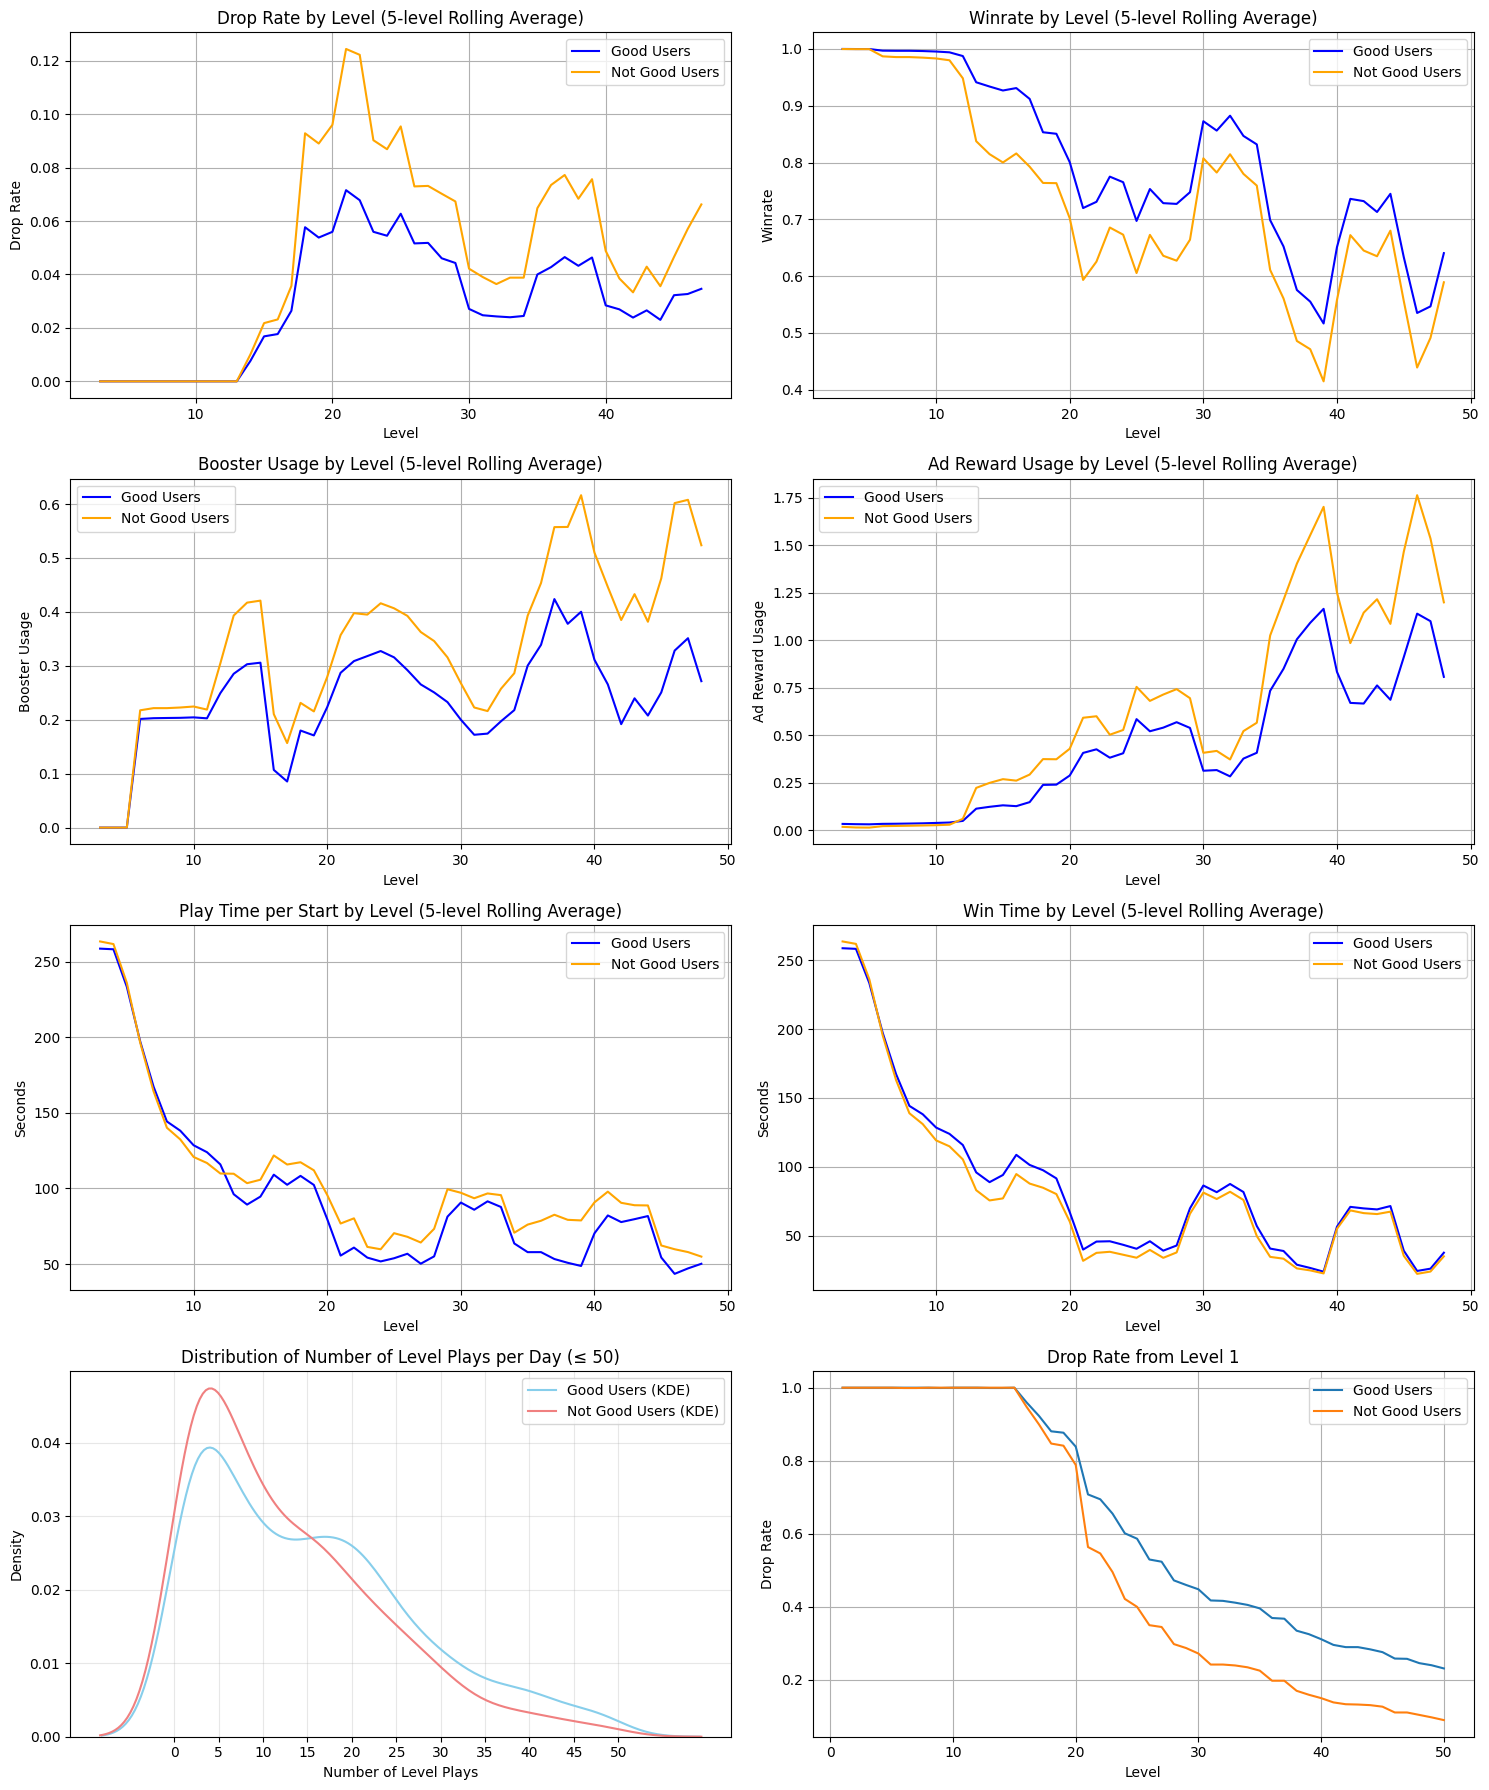

In [50]:
# Filter data for level <= 50
filtered_data = winrate_combined[winrate_combined['level'] <= 50]

# Create figure and subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 18))

# Calculate 5-level rolling averages
drop_good_rolling = filtered_data['drop_by_level_good_user'].rolling(window=5, center=True).mean()
drop_not_good_rolling = filtered_data['drop_by_level_not_good_user'].rolling(window=5, center=True).mean()
winrate_good_rolling = filtered_data['winrate_good_user'].rolling(window=5, center=True).mean()
winrate_not_good_rolling = filtered_data['winrate_not_good_user'].rolling(window=5, center=True).mean()
booster_good_rolling = filtered_data['num_booster_use_per_start_good_user'].rolling(window=5, center=True).mean()
booster_not_good_rolling = filtered_data['num_booster_use_per_start_not_good_user'].rolling(window=5, center=True).mean()
ad_good_rolling = filtered_data['num_ad_reward_per_start_good_user'].rolling(window=5, center=True).mean()
ad_not_good_rolling = filtered_data['num_ad_reward_per_start_not_good_user'].rolling(window=5, center=True).mean()
play_good_rolling = filtered_data['play_level_time_sec_per_start_good_user'].rolling(window=5, center=True).mean()
play_not_good_rolling = filtered_data['play_level_time_sec_per_start_not_good_user'].rolling(window=5, center=True).mean()
win_good_rolling = filtered_data['win_level_time_sec_per_start_good_user'].rolling(window=5, center=True).mean()
win_not_good_rolling = filtered_data['win_level_time_sec_per_start_not_good_user'].rolling(window=5, center=True).mean()

# Plot drop rates by level
axes[0,0].plot(filtered_data['level'], drop_good_rolling, color='blue', label='Good Users')
axes[0,0].plot(filtered_data['level'], drop_not_good_rolling, color='orange', label='Not Good Users')
axes[0,0].set_title('Drop Rate by Level (5-level Rolling Average)')
axes[0,0].set_xlabel('Level')
axes[0,0].set_ylabel('Drop Rate')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot winrates
axes[0,1].plot(filtered_data['level'], winrate_good_rolling, color='blue', label='Good Users')
axes[0,1].plot(filtered_data['level'], winrate_not_good_rolling, color='orange', label='Not Good Users')
axes[0,1].set_title('Winrate by Level (5-level Rolling Average)')
axes[0,1].set_xlabel('Level')
axes[0,1].set_ylabel('Winrate')
axes[0,1].legend()
axes[0,1].grid(True)

# Plot booster usage
axes[1,0].plot(filtered_data['level'], booster_good_rolling, color='blue', label='Good Users')
axes[1,0].plot(filtered_data['level'], booster_not_good_rolling, color='orange', label='Not Good Users')
axes[1,0].set_title('Booster Usage by Level (5-level Rolling Average)')
axes[1,0].set_xlabel('Level')
axes[1,0].set_ylabel('Booster Usage')
axes[1,0].legend()
axes[1,0].grid(True)

# Plot ad reward usage
axes[1,1].plot(filtered_data['level'], ad_good_rolling, color='blue', label='Good Users')
axes[1,1].plot(filtered_data['level'], ad_not_good_rolling, color='orange', label='Not Good Users')
axes[1,1].set_title('Ad Reward Usage by Level (5-level Rolling Average)')
axes[1,1].set_xlabel('Level')
axes[1,1].set_ylabel('Ad Reward Usage')
axes[1,1].legend()
axes[1,1].grid(True)

# Plot play time per start
axes[2,0].plot(filtered_data['level'], play_good_rolling, color='blue', label='Good Users')
axes[2,0].plot(filtered_data['level'], play_not_good_rolling, color='orange', label='Not Good Users')
axes[2,0].set_title('Play Time per Start by Level (5-level Rolling Average)')
axes[2,0].set_xlabel('Level')
axes[2,0].set_ylabel('Seconds')
axes[2,0].legend()
axes[2,0].grid(True)

# Plot win time
axes[2,1].plot(filtered_data['level'], win_good_rolling, color='blue', label='Good Users')
axes[2,1].plot(filtered_data['level'], win_not_good_rolling, color='orange', label='Not Good Users')
axes[2,1].set_title('Win Time by Level (5-level Rolling Average)')
axes[2,1].set_xlabel('Level')
axes[2,1].set_ylabel('Seconds')
axes[2,1].legend()
axes[2,1].grid(True)

# Plot KDE of number of level plays
sns.kdeplot(data=filtered_data_good['num_level_play'], bw_adjust=1.5, color='skyblue', label='Good Users (KDE)', ax=axes[3,0])
sns.kdeplot(data=filtered_data_not_good['num_level_play'], bw_adjust=1.5, color='lightcoral', label='Not Good Users (KDE)', ax=axes[3,0])
axes[3,0].set_xlabel('Number of Level Plays')
axes[3,0].set_ylabel('Density')
axes[3,0].set_title('Distribution of Number of Level Plays per Day (≤ 50)')
axes[3,0].set_xticks(range(0, 51, 5))
axes[3,0].grid(True, alpha=0.3)
axes[3,0].legend()

# Plot drop rates from level 1
axes[3,1].plot(filtered_data['level'], filtered_data['drop_by_lv1_good_user'], label='Good Users')
axes[3,1].plot(filtered_data['level'], filtered_data['drop_by_lv1_not_good_user'], label='Not Good Users')
axes[3,1].set_title('Drop Rate from Level 1')
axes[3,1].set_xlabel('Level')
axes[3,1].set_ylabel('Drop Rate')
axes[3,1].legend()
axes[3,1].grid(True)

plt.tight_layout()
plt.show()

# Attemp level 

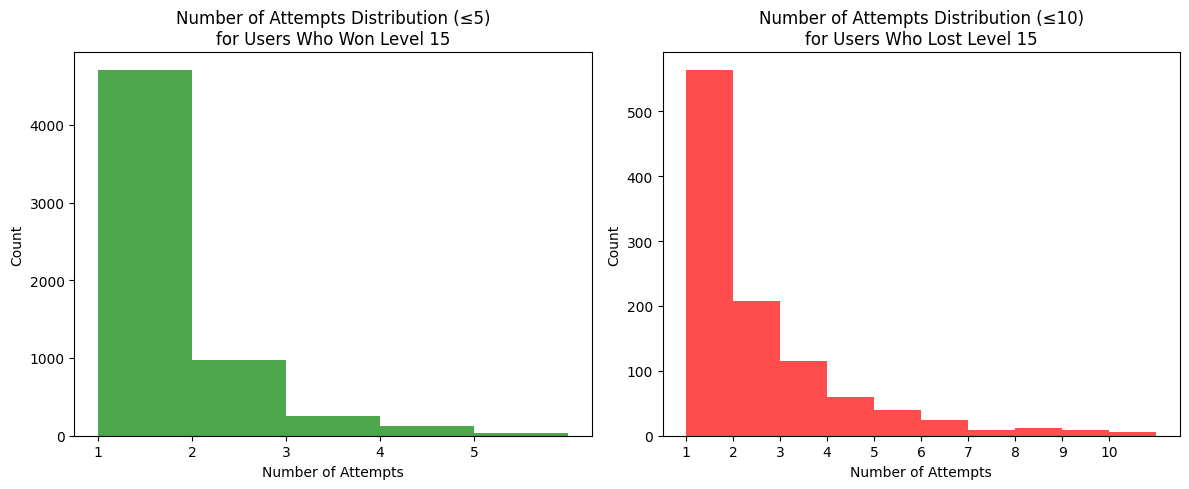

,user_pseudo_id,num_attempt,label_user
0,33d85bdd21998ca15ebe8ee684f8a03c,2,user_win_lv15
1,da9b0f9fd524dfd692f1636d036abb20,2,user_win_lv15
2,03f8b90ea77e34b6a8b41a47cbfbd9a3,1,user_win_lv15
3,dde5f31eb1a8ad3dc38c65e040d7db77,1,user_win_lv15
4,1b9d9f453b693f032c6494c16c20dbaf,2,user_win_lv15
...,...,...,...
7255,ed23ad0bec53c9d405eec68da8d82f6e,1,user_win_lv15
7256,fe8425869ae1b13d53f4b060879ee46c,1,user_win_lv15
7257,9eda7fc7c17d0d5079427870c9d9b71a,2,user_win_lv15
7258,db5e7c1e5b1eff41a581c92e8da18c07,1,user_win_lv15


In [53]:
query = """ 
with user_win_lv15 as (
    select distinct user_pseudo_id
    from `crazy-coffee-jam.flatten_table.win_level`
    where level = 15
    and event_date >= '2025-05-01'
)
, user_lose_lv15 as (
    select distinct user_pseudo_id
    from `crazy-coffee-jam.flatten_table.start_level`
    where level = 15
    and event_date >= '2025-05-01'
    and user_pseudo_id not in (select user_pseudo_id from user_win_lv15)
)
select 
    user_pseudo_id,
    count(user_pseudo_id) as num_attempt,
    case when user_pseudo_id in (select user_pseudo_id from user_win_lv15) then 'user_win_lv15'
    when user_pseudo_id in (select user_pseudo_id from user_lose_lv15) then 'user_lose_lv15'
    else 'other' end as label_user
from `crazy-coffee-jam.flatten_table.start_level`
where level = 15
and event_date >= '2025-05-01'
and ( user_pseudo_id  in (select user_pseudo_id from user_win_lv15)
or user_pseudo_id in (select user_pseudo_id from user_lose_lv15))
group by user_pseudo_id
"""
attemp_level_15 = client.query(query).to_dataframe()
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for users who won level 15
win_users = attemp_level_15[attemp_level_15['label_user'] == 'user_win_lv15']
win_users = win_users[win_users['num_attempt'] <= 5]
ax1.hist(win_users['num_attempt'], bins=range(1,7), color='green', alpha=0.7)
ax1.set_title('Number of Attempts Distribution (≤5)\nfor Users Who Won Level 15')
ax1.set_xlabel('Number of Attempts')
ax1.set_ylabel('Count')
ax1.set_xticks(range(1,6))

# Plot histogram for users who lost level 15
lose_users = attemp_level_15[attemp_level_15['label_user'] == 'user_lose_lv15']
lose_users = lose_users[lose_users['num_attempt'] <= 10]
ax2.hist(lose_users['num_attempt'], bins=range(1,12), color='red', alpha=0.7)
ax2.set_title('Number of Attempts Distribution (≤10)\nfor Users Who Lost Level 15')
ax2.set_xlabel('Number of Attempts')
ax2.set_ylabel('Count')
ax2.set_xticks(range(1,11))

plt.tight_layout()
plt.show()

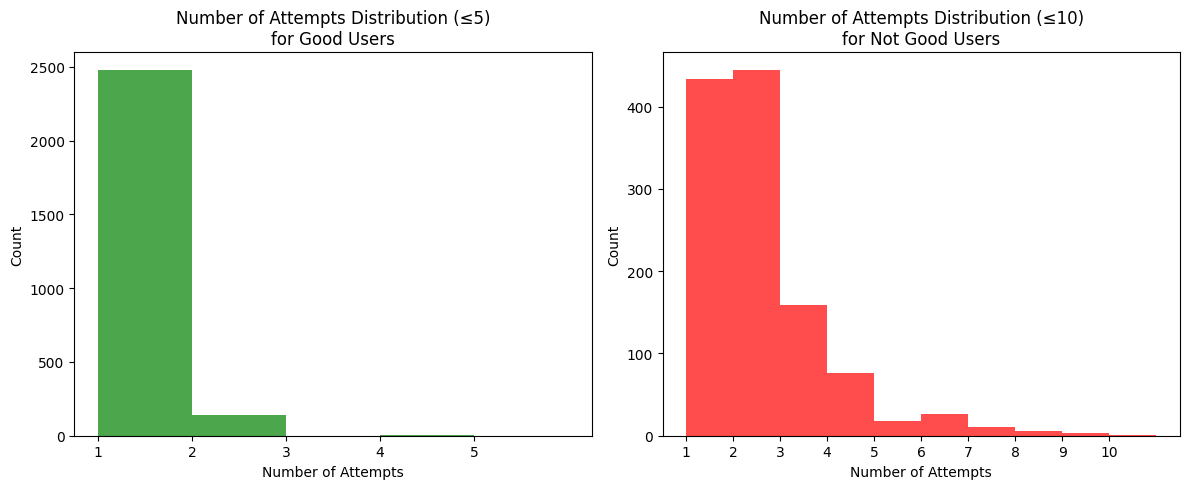

In [57]:
query = f""" 
select 
    user_pseudo_id,
    count(user_pseudo_id) as num_attempt,
    case when user_pseudo_id in ('{good_user_list_str}') then 'good_user_attempt_lv15'
    when user_pseudo_id in ('{not_good_user_list_str}') then 'not_good_user_attempt_lv15'
    else 'other' end as label_user
from `crazy-coffee-jam.flatten_table.start_level`
where level = 15
and event_date >= '2025-05-01'
and ( user_pseudo_id  in ('{good_user_list_str}')
or user_pseudo_id in ('{not_good_user_list_str}'))
group by user_pseudo_id
"""
attemp_level_15 = client.query(query).to_dataframe()
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for users who won level 15
win_users = attemp_level_15[attemp_level_15['label_user'] == 'good_user_attempt_lv15']
win_users = win_users[win_users['num_attempt'] <= 5]
ax1.hist(win_users['num_attempt'], bins=range(1,7), color='green', alpha=0.7)
ax1.set_title('Number of Attempts Distribution (≤5)\nfor Good Users')
ax1.set_xlabel('Number of Attempts')
ax1.set_ylabel('Count')
ax1.set_xticks(range(1,6))

# Plot histogram for users who lost level 15
lose_users = attemp_level_15[attemp_level_15['label_user'] == 'not_good_user_attempt_lv15']
lose_users = lose_users[lose_users['num_attempt'] <= 10]
ax2.hist(lose_users['num_attempt'], bins=range(1,12), color='red', alpha=0.7)
ax2.set_title('Number of Attempts Distribution (≤10)\nfor Not Good Users')
ax2.set_xlabel('Number of Attempts')
ax2.set_ylabel('Count')
ax2.set_xticks(range(1,11))

plt.tight_layout()
plt.show()

# Attemp level 20 

In [31]:
query = f"""
with win_level_20 as (
  select distinct user_pseudo_id 
  from `crazy-coffee-jam.flatten_table.win_level`
  where event_date >= '2025-05-01'
  and level >= 20
), drop_level_20 as(
  select distinct user_pseudo_id
  from `crazy-coffee-jam.flatten_table.level_data`
  where event_date between '2025-05-01' and '2025-05-19'
  and level = 20
  and user_pseudo_id not in (select user_pseudo_id from win_level_20)
  and event_end_level_timestamp is null 
)
select
    user_pseudo_id,
    level,
    attempt_times,
    booster_use,
    ad_rewards,
    case when user_pseudo_id in ('{good_user_list_str}') then 'good_user'
    when user_pseudo_id in ('{not_good_user_list_str}') then 'not_good_user'
    else 'other' end as label_user
from `crazy-coffee-jam.dashboard_table.level_data`
where level = 20
and event_date >= '2025-05-01' 
and ( user_pseudo_id  in ('{good_user_list_str}')
or user_pseudo_id in ('{not_good_user_list_str}'))
and user_pseudo_id  in (select user_pseudo_id from drop_level_20)
"""
attemp_level_20 = client.query(query).to_dataframe()
attemp_level_20

,user_pseudo_id,level,attempt_times,booster_use,ad_rewards,label_user
0,006ce4d5bad5e680817f4cde35bfbb49,20,1,0,0,good_user
1,093a1473a648100edc457b1144ceff3b,20,1,0,7,good_user
2,0a04cc6f276ad1f33d17b1bbd511424f,20,1,0,0,good_user
3,1076189067e2483536fc5938f22633db,20,8,0,0,not_good_user
4,1076189067e2483536fc5938f22633db,20,7,0,0,not_good_user
...,...,...,...,...,...,...
2071,be4d040a2ef48479a9e53e3fa2bda1f9,20,1,1,0,not_good_user
2072,de34a0d1a4da7f850c0a1cad03452a4e,20,3,1,2,good_user
2073,81072339da4344357b2957d4e1629a21,20,2,2,0,good_user
2074,aaef4ac0b9dd7aab059dc08b96e07bc3,20,1,2,3,good_user


In [32]:
attemp_level_20.groupby('label_user')['user_pseudo_id'].nunique()

label_user
good_user        387
not_good_user    409
Name: user_pseudo_id, dtype: int64

In [33]:
attemp_level_20['use_resource'] = attemp_level_20['booster_use'] + attemp_level_20['ad_rewards']

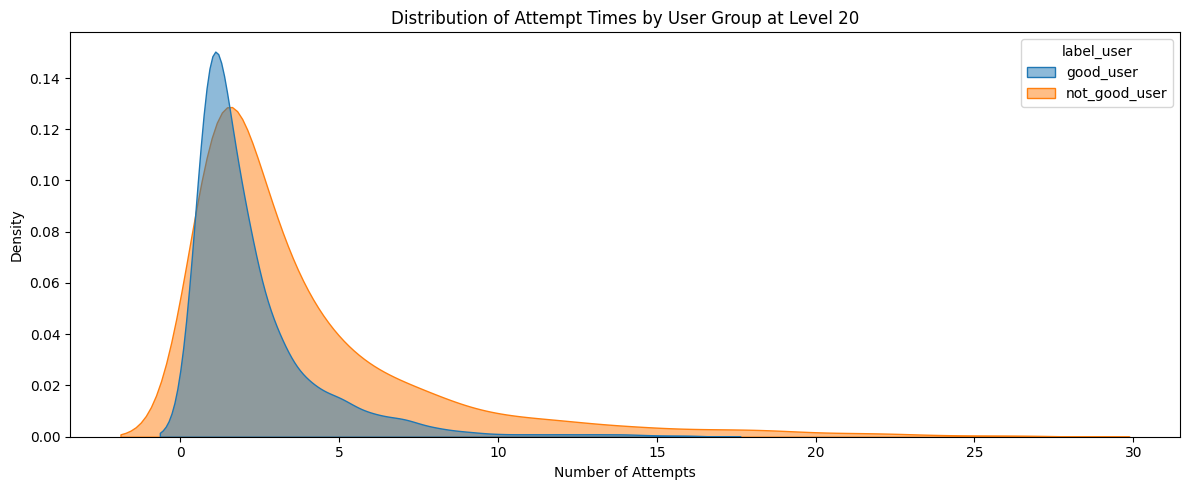

In [34]:
plt.figure(figsize=(12,5))

# Create KDE plot for attempt times by cluster
sns.kdeplot(data=attemp_level_20, x='attempt_times', hue='label_user', fill=True, alpha=0.5)

plt.title('Distribution of Attempt Times by User Group at Level 20')
plt.xlabel('Number of Attempts')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [38]:
# Group by attempt_times and calculate metrics for each user group
attempt_summary = attemp_level_20.groupby('attempt_times').agg(
    num_user_good=('label_user', lambda x: (x == 'good_user').sum()),
    num_user_not_good=('label_user', lambda x: (x == 'not_good_user').sum()),
    num_booster_used_by_user_good=('booster_use', lambda x: x[attemp_level_20['label_user'] == 'good_user'].sum()),
    num_booster_used_by_user_not_good=('booster_use', lambda x: x[attemp_level_20['label_user'] == 'not_good_user'].sum()),
    num_adreward_used_by_user_good=('ad_rewards', lambda x: x[attemp_level_20['label_user'] == 'good_user'].sum()),
    num_adreward_used_by_user_not_good=('ad_rewards', lambda x: x[attemp_level_20['label_user'] == 'not_good_user'].sum())
).reset_index()

attempt_summary

,attempt_times,num_user_good,num_user_not_good,num_booster_used_by_user_good,num_booster_used_by_user_not_good,num_adreward_used_by_user_good,num_adreward_used_by_user_not_good
0,1,387,409,91,64,236,254
1,2,182,268,44,58,81,100
2,3,83,163,15,20,33,48
3,4,43,109,12,19,17,39
4,5,32,76,7,13,17,33
5,6,18,54,2,8,3,9
6,7,15,45,4,8,13,10
7,8,7,35,2,6,2,15
8,9,4,23,0,3,0,9
9,10,2,18,0,0,0,4


In [39]:
attempt_summary['num_resource_used_by_user_good'] = attempt_summary['num_booster_used_by_user_good'] + attempt_summary['num_adreward_used_by_user_good']
attempt_summary['num_resource_used_by_user_not_good'] = attempt_summary['num_booster_used_by_user_not_good'] + attempt_summary['num_adreward_used_by_user_not_good']
attempt_summary['num_resource_used_per_user_not_good'] = attempt_summary['num_resource_used_by_user_not_good']/attempt_summary['num_user_not_good']
attempt_summary['num_resource_used_per_user_good'] = attempt_summary['num_resource_used_by_user_good']/attempt_summary['num_user_good']

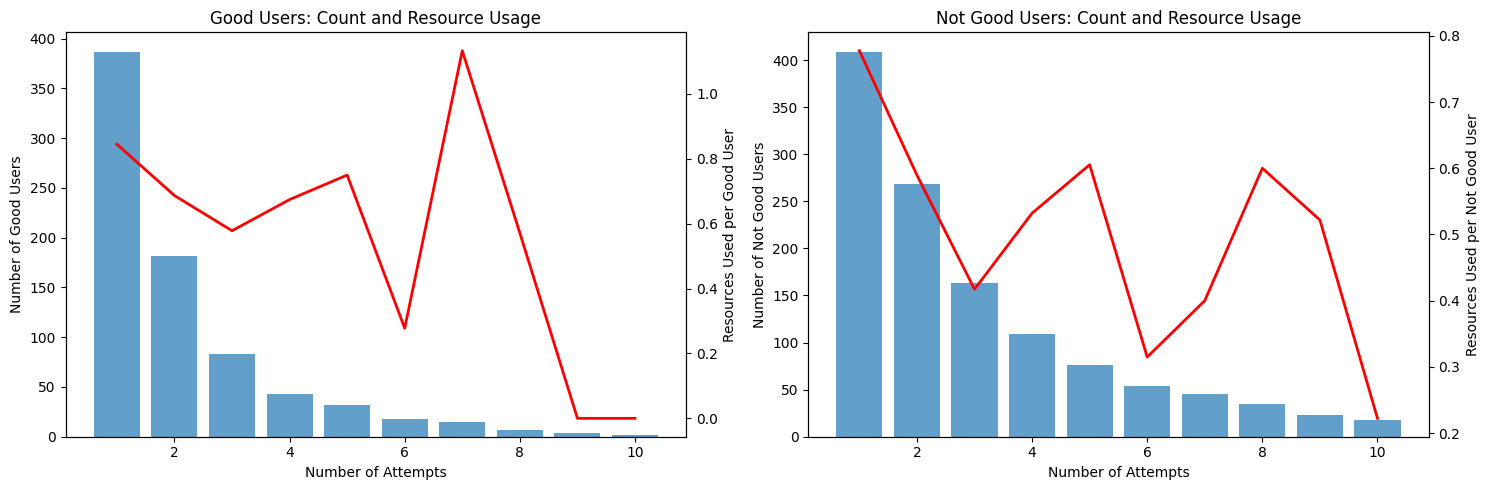

In [40]:
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot for good users
ax1_bar = ax1.bar(attempt_summary['attempt_times'], attempt_summary['num_user_good'], alpha=0.7)
ax1_line = ax1.twinx()
ax1_line.plot(attempt_summary['attempt_times'], attempt_summary['num_resource_used_per_user_good'], 
              color='red', linewidth=2)

ax1.set_xlabel('Number of Attempts')
ax1.set_ylabel('Number of Good Users')
ax1_line.set_ylabel('Resources Used per Good User')
ax1.set_title('Good Users: Count and Resource Usage')

# Plot for not good users  
ax2_bar = ax2.bar(attempt_summary['attempt_times'], attempt_summary['num_user_not_good'], alpha=0.7)
ax2_line = ax2.twinx()
ax2_line.plot(attempt_summary['attempt_times'], attempt_summary['num_resource_used_per_user_not_good'],
              color='red', linewidth=2)

ax2.set_xlabel('Number of Attempts') 
ax2.set_ylabel('Number of Not Good Users')
ax2_line.set_ylabel('Resources Used per Not Good User')
ax2.set_title('Not Good Users: Count and Resource Usage')

plt.tight_layout()
plt.show()

In [41]:
attemp_level_20

,user_pseudo_id,level,attempt_times,booster_use,ad_rewards,label_user,use_resource
0,006ce4d5bad5e680817f4cde35bfbb49,20,1,0,0,good_user,0
1,093a1473a648100edc457b1144ceff3b,20,1,0,7,good_user,7
2,0a04cc6f276ad1f33d17b1bbd511424f,20,1,0,0,good_user,0
3,1076189067e2483536fc5938f22633db,20,8,0,0,not_good_user,0
4,1076189067e2483536fc5938f22633db,20,7,0,0,not_good_user,0
...,...,...,...,...,...,...,...
2071,be4d040a2ef48479a9e53e3fa2bda1f9,20,1,1,0,not_good_user,1
2072,de34a0d1a4da7f850c0a1cad03452a4e,20,3,1,2,good_user,3
2073,81072339da4344357b2957d4e1629a21,20,2,2,0,good_user,2
2074,aaef4ac0b9dd7aab059dc08b96e07bc3,20,1,2,3,good_user,5


In [42]:
# get max attemp of user_pseudo_id
df = attemp_level_20.loc[attemp_level_20.groupby('user_pseudo_id')['attempt_times'].idxmax()]
df

,user_pseudo_id,level,attempt_times,booster_use,ad_rewards,label_user,use_resource
0,006ce4d5bad5e680817f4cde35bfbb49,20,1,0,0,good_user,0
584,01112815f2b4d843fcfaab2f03aa52e3,20,10,0,0,not_good_user,0
1423,011aa5895e4249ed453fbd7720872455,20,2,2,2,not_good_user,4
1741,0189a8a782acb2abfc91870fcc7ec69f,20,1,0,0,not_good_user,0
1253,01e623a4f7c56e8a17c81aca7496ba6f,20,2,0,0,not_good_user,0
...,...,...,...,...,...,...,...
975,fedc4dca8da7893ee44e96403c369cda,20,1,0,0,good_user,0
295,ff997151e62228c2bf6bf1ef6b74229d,20,4,0,0,not_good_user,0
689,ff9e95f5d713a3f0082d38648d9af5fa,20,1,0,0,not_good_user,0
1393,ffce8f6252f04ac2ce8403705cc95eae,20,1,0,0,not_good_user,0


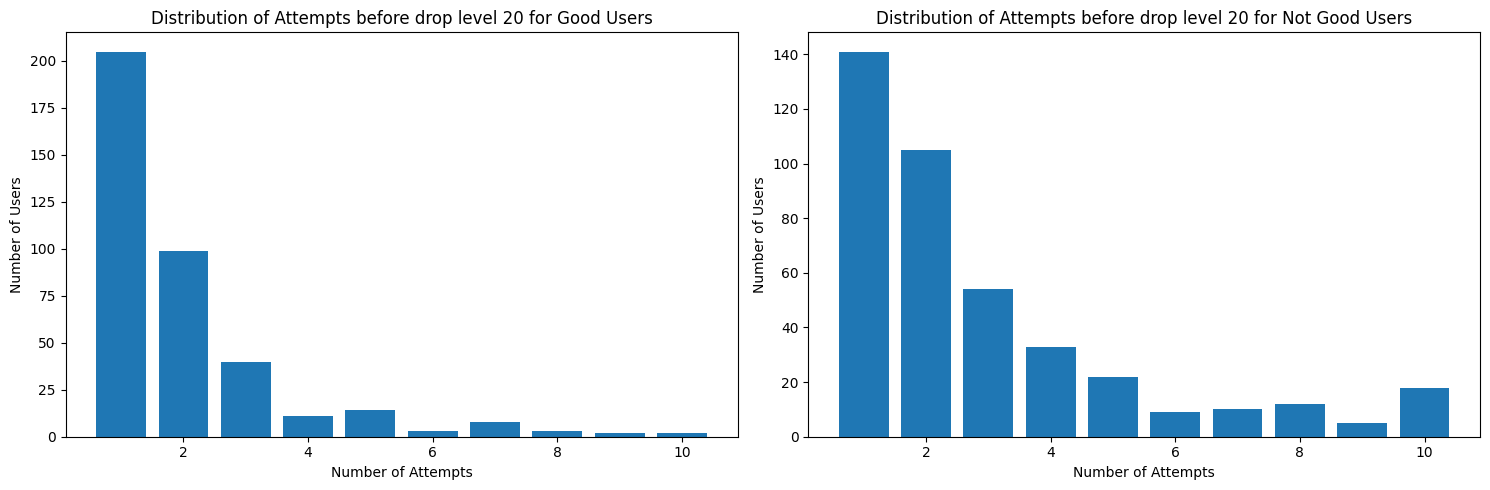

In [43]:
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot for good users
good_users = df[df['label_user'] == 'good_user']
good_users_count = good_users['attempt_times'].value_counts().sort_index()
ax1.bar(good_users_count.index, good_users_count.values)
ax1.set_xlabel('Number of Attempts')
ax1.set_ylabel('Number of Users')
ax1.set_title('Distribution of Attempts before drop level 20 for Good Users')

# Plot for not good users
not_good_users = df[df['label_user'] == 'not_good_user'] 
not_good_users_count = not_good_users['attempt_times'].value_counts().sort_index()
ax2.bar(not_good_users_count.index, not_good_users_count.values)
ax2.set_xlabel('Number of Attempts')
ax2.set_ylabel('Number of Users')
ax2.set_title('Distribution of Attempts before drop level 20 for Not Good Users')

plt.tight_layout()
plt.show()

In [45]:
# Group by attempt_times and calculate metrics for each user group
df_summary = df.groupby('attempt_times').agg(
    num_user_good=('label_user', lambda x: (x == 'good_user').sum()),
    num_user_not_good=('label_user', lambda x: (x == 'not_good_user').sum()),
    num_resource_used_by_user_good=('use_resource', lambda x: x[df['label_user'] == 'good_user'].sum()),
    num_resource_used_by_user_not_good=('use_resource', lambda x: x[df['label_user'] == 'not_good_user'].sum())
).reset_index()

df_summary

,attempt_times,num_user_good,num_user_not_good,num_resource_used_by_user_good,num_resource_used_by_user_not_good
0,1,205,141,164,118
1,2,99,105,64,47
2,3,40,54,19,29
3,4,11,33,10,14
4,5,14,22,13,8
5,6,3,9,0,7
6,7,8,10,12,3
7,8,3,12,2,5
8,9,2,5,0,6
9,10,2,18,0,4


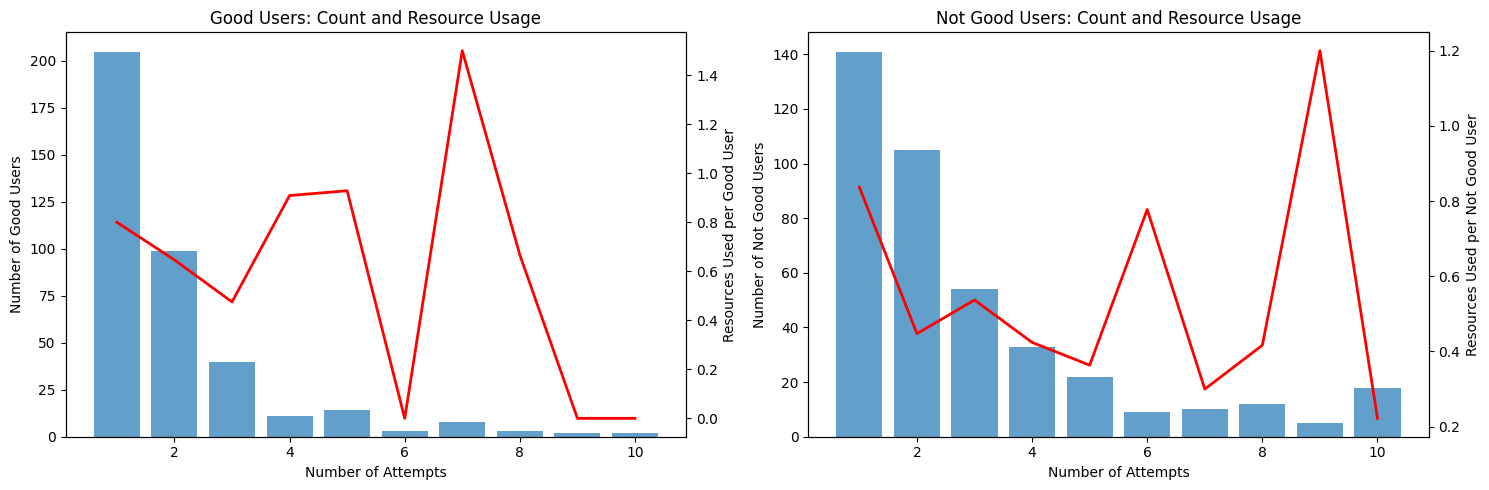

In [46]:
df_summary['num_resource_used_per_user_not_good'] = df_summary['num_resource_used_by_user_not_good']/df_summary['num_user_not_good']
df_summary['num_resource_used_per_user_good'] = df_summary['num_resource_used_by_user_good']/df_summary['num_user_good']
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot for good users
ax1_bar = ax1.bar(df_summary['attempt_times'], df_summary['num_user_good'], alpha=0.7)
ax1_line = ax1.twinx()
ax1_line.plot(df_summary['attempt_times'], df_summary['num_resource_used_per_user_good'], 
              color='red', linewidth=2)

ax1.set_xlabel('Number of Attempts')
ax1.set_ylabel('Number of Good Users')
ax1_line.set_ylabel('Resources Used per Good User')
ax1.set_title('Good Users: Count and Resource Usage')   

# Plot for not good users
ax2_bar = ax2.bar(df_summary['attempt_times'], df_summary['num_user_not_good'], alpha=0.7)
ax2_line = ax2.twinx()
ax2_line.plot(df_summary['attempt_times'], df_summary['num_resource_used_per_user_not_good'],
              color='red', linewidth=2)

ax2.set_xlabel('Number of Attempts')
ax2.set_ylabel('Number of Not Good Users')
ax2_line.set_ylabel('Resources Used per Not Good User')
ax2.set_title('Not Good Users: Count and Resource Usage')

plt.tight_layout()
plt.show()
